# MFCC Features for Masks

Simple example of linear regression being used in conjunction with MFCCs.

In [1]:
# Speech Libraries
from python_speech_features import mfcc, get_filterbanks
from python_speech_features.sigproc import deframesig
from psf_supplement import specdecomp

## Wave libraries
from IPython.display import Audio
from IPython.display import display
import scipy.io.wavfile as wav

## Standard python libraries
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

## Mixing two signals together

In [2]:
audio_dir = "sisec/"
fs, snda = wav.read(audio_dir+"dev_Ca1_Ce_A_src.wav")
fs, sndb = wav.read(audio_dir+"dev_Ca1_Ce_B_src.wav")

sndab = snda+sndb

## Parameters

In [3]:
# Parameters
nfilt=64
numcep=64
nfft=512
winlen=0.01
winstep=0.005
ceplifter=0

## Feature extraction and spectral decomposition

In [4]:
# We can extract MFCC features from the combination of A & B signals
mfcc_feat = mfcc(sndab,fs,nfilt=nfilt,numcep=numcep,nfft=nfft,
                 winlen=winlen,winstep=winstep,ceplifter=ceplifter,
                 appendEnergy=False)

# Since python_speech_features takes spectrograms differently than 
# you or I might, I've included the library in psf_supplement.py.
mfcc_magni = specdecomp(sndab,samplerate=fs,nfft=nfft,
                        winlen=winlen,winstep=winstep,decomp='abs')
mfcc_phase = specdecomp(sndab,samplerate=fs,nfft=nfft,
                        winlen=winlen,winstep=winstep,decomp='phase')

# Labeled mask requires situations where the desired signal is larger 
# than the noise. In this case, we require magnitude responses of signals
# A and B (the signal and noise).
magni_A = specdecomp(snda,samplerate=fs,nfft=nfft,
                     winlen=winlen,winstep=winstep,decomp='abs')
magni_B = specdecomp(sndb,samplerate=fs,nfft=nfft,
                     winlen=winlen,winstep=winstep,decomp='abs')

# Define the mask
mask = magni_A > magni_B

## Deep Neural Network Solution

Let $X \in \mathbb{R}^{N \times f}$ be the input MFCC features of dimension $f$, in code called `mfcc_feat`. Let $Y \in \mathbb{R}^{N \times d}$ be the output magnitude mask  (called `mask`) of size `nfft`. Then, the linear regression would be:

$$ Y^T = A X^T $$

and the least squares solution (it should be overdetermined) is determined by:  

$$ A = Y^T X ( X^T X )^{-1} $$

In [5]:
A = mask.T @ mfcc_feat @ np.linalg.inv(mfcc_feat.T @ mfcc_feat)

## Recover FFT magnitude

First recover the magnitude response through power spectrum.

In [6]:
mask_recon = (A @ mfcc_feat.T).T
snda_recon = (mask_recon * magni_A) * np.exp( 1j *  mfcc_phase )
snda_recon = np.fft.irfft( snda_recon )
snda_recon = snda_recon[:,:(int(fs*winlen))]

snda_recon = deframesig(snda_recon, 0, int(fs*winlen), int(fs*winstep))

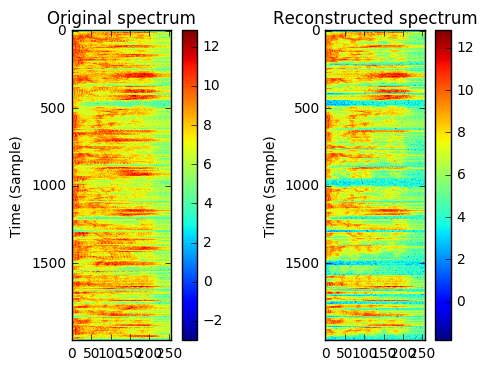

In [7]:
snda_recon = snda_recon.astype(np.int16)
plt.subplot(121); plt.imshow(np.log(mfcc_magni),aspect=0.4); 
plt.title('Original spectrum'); plt.colorbar(); plt.ylabel('Time (Sample)')
plt.subplot(122); plt.imshow(np.log(magni_A),aspect=0.4); 
plt.title('Reconstructed spectrum'); plt.colorbar(); plt.ylabel('Time (Sample)')
display(Audio(snda,rate=fs))
display(Audio(snda_recon,rate=fs))
